# Adversarial Patch attack

Adversarial patch attack seeks to replace a part of an input image with a patch trained on a variety of images.
This patch is created by replacing part of an image. This involves:
    - creating a patch
    - applying a random translation, scaling and rotation to the patch at a given location. 
    - training the patch to optimize the expected probability of a target class using gradient descent.
  
 The following example demonestrates a white-box adversarial patch attack.

First, install a small utility tool created by Tom Brown [1](https://arxiv.org/pdf/1712.09665.pdf)  

In [1]:
import sys
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs

Load packages and modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import random
import numpy as np

from PIL import Image as Im
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label
import warnings


from art.classifiers.tensorflow import TFClassifier
from art.attacks import AdversarialPatch


%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [6, 6] # plot size


### Parameters

Conducting a white-box attack involves an adversary with full knowledge of the model's architecture, hyper-parameters, activation function, weights as well as the number of layers.

In [2]:
image_shape = (224, 224, 3)
batch_size = 3
scale_min = 0.3
scale_max = 1.0
rotation_max = 22.5
learning_rate = 200000.0
max_iter = 1000

# Model definition

#### Target Class

In [3]:
target_image_name = 'toaster.jpg'

The target class is the expected label to be predicted by a classifier. The adversarial patch is responsible for misleading a classifier to predict an input image as the target class rather than the actual content/label or class of the image. This is because the patch is rained to optimize the expected probability of the target class.

Intiate the class for running TensorFlow operations and load input

In [4]:
sess = tf.InteractiveSession()
_image_input = tf.keras.Input(shape=image_shape)

Create a placeholder for tensorflow to hold a tensor for the patch we're designing to insert the target class/label with a 100x100. 

In [5]:
_target_ys = tf.placeholder(tf.float32, shape=(None, 1000))

Load the model and its weights

In [6]:
model = ResNet50(input_tensor=_image_input, 
                 weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


Get the Pre-softmax logits of our pretrained model. This is the vector of raw (non-normalized) predictions that was generated by the classification model.

In [7]:
_logits = model.outputs[0].op.inputs[0]

Next compute for the target loss. This goal is to the attack and minimize the loss of the target label by computing the softmax cross entrophy between the pretrained weights and the target label.


In [8]:
target_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=_target_ys, logits=_logits))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



#### Classifier

In order to generate the adversarial patch, we'll need to train a classifier model on the sample dataset we just prepared. This classifier will attempt to minimize the loss of the target label (*toaster*) using the pretrained weight while being trained on a dataset that has nothing to do with a toaster.

In [9]:
tfc = TFClassifier(clip_values=(0, 1), 
                   input_ph=_image_input, 
                   output_ph=_target_ys, 
                   logits=_logits,
                   sess=sess, 
                   loss=target_loss)

Instructions for updating:
Use tf.cast instead.


#### Load data

In [10]:

#data_dir ="./images/"
data_dir ="./data/"

images_stack = []

for file in glob.glob(data_dir+"*.jpg"):
    images = image.load_img(file, target_size=(224,224))
    numpy_image = image.img_to_array(images)
    original_img_batch = np.expand_dims(numpy_image, axis=0) 
    images_stack.append(original_img_batch)

concated_images = np.concatenate(images_stack)    

#### predict and visualize the original images

In [11]:
def predict_image(model, image): 
    
    predicted_outputs = []
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)

    top = 3
    prediction = model.predict(image)
    prediction_decode = decode_predictions(prediction, top=top)[0]

    lengths = list()

    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)

    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)

        predicted_outputs.append(output_str)

    return predicted_outputs


#### Visualize

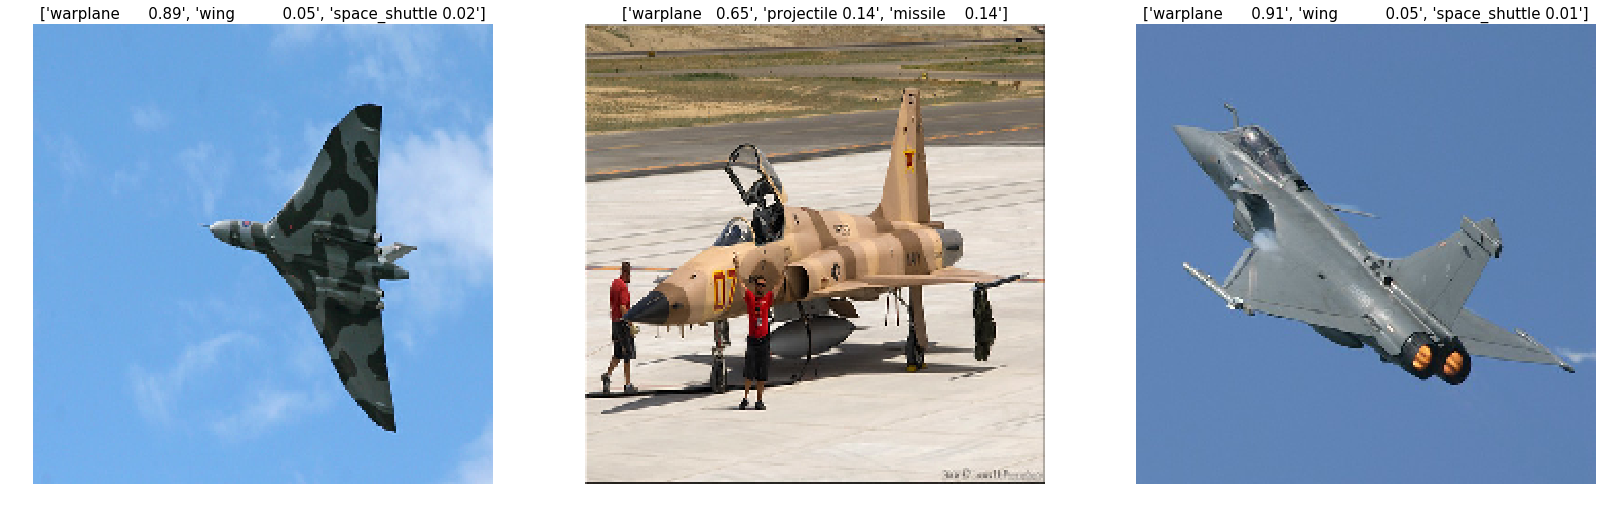

In [12]:
fig = plt.subplots(1,3, figsize =(28,28))
#label
first_img = predict_image(model, concated_images[0, :, :, :])
second_img = predict_image(model, concated_images[1, :, :, :])
third_img = predict_image(model, concated_images[2, :, :, :])

plt.subplot(131), plt.imshow(np.uint8(concated_images[0])), plt.title(first_img,fontsize=15),plt.axis('off')
plt.subplot(132), plt.imshow(np.uint8(concated_images[1])), plt.title(second_img,fontsize=15),plt.axis('off')
plt.subplot(133), plt.imshow(np.uint8(concated_images[2])), plt.title(third_img,fontsize=15),plt.axis('off')

plt.show()

### Prepare image for Keras.

Keras expects images to have BGR rather than RGB.

In [13]:
concated_images_for_keras = preprocess_input(concated_images)

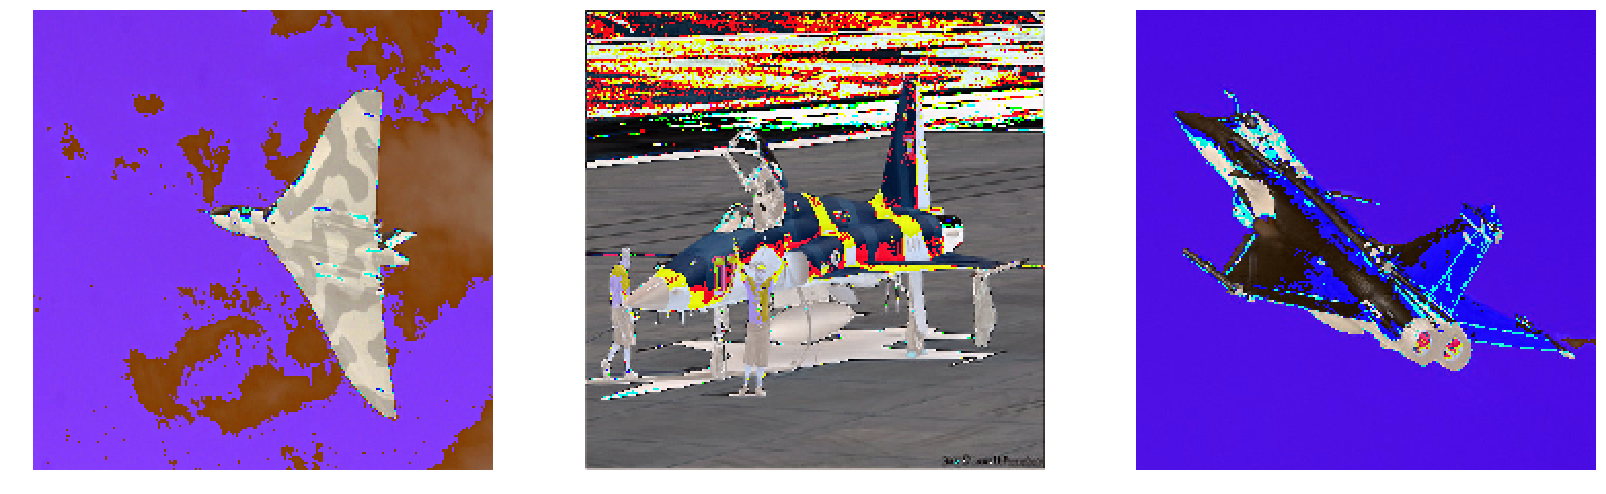

In [15]:
fig=plt.figure(figsize=(28, 28))
w =15
h = 15
columns = 3
rows = 1
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.uint8(concated_images_for_keras[i-1]))
    plt.axis('off')

plt.show()

### Generate Adversarial Patch

Set the classifier and the patch

In [21]:
ap = AdversarialPatch(classifier=tfc, 
                      target=name_to_label('toaster'), 
                      rotation_max=rotation_max,
                      scale_min=scale_min, 
                      scale_max=scale_max, 
                      learning_rate=learning_rate, 
                      max_iter=max_iter,
                      batch_size=batch_size, 
                      clip_patch=[(-103.939, 255.0 - 103.939), 
                                  (-116.779, 255.0 - 116.779),
                                  (-123.680, 255.0 - 123.680)])


The new weights obtained by the image classifier will be used for creating the pixel values of the adverserial patch. 

In [22]:
patch, patch_mask = ap.generate(x=concated_images_for_keras)

#### Save the patch

The following function will allow us to normalize the images using ImageNet dataset's mean pixel value.

In [26]:
def from_keras(x):
    x = np.copy(x)
    x[:, :, 2] += 123.68
    x[:, :, 1] += 116.779
    x[:, :, 0] += 103.939
    return x[:, :, [2, 1, 0]].astype(np.uint8)

In [27]:
imagenet_patch = (from_keras(patch) * patch_mask).astype(np.uint8)
plt.imsave('adversarial_patch.jpg', imagenet_patch)

#### Visualize the patch

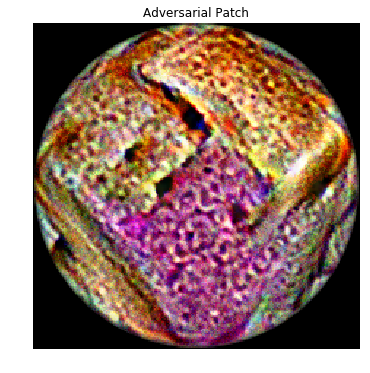

In [31]:
#fig = plt.figure(figsize =(6,6))
plt.rcParams['figure.figsize'] = [6, 6] # plot size

plt.imshow(imagenet_patch)

plt.title('Adversarial Patch')
plt.axis('off')
plt.show()

### Evaluation

Apply the patch to the original dataset used for training the model. The authors of the paper *Adversarial Patch* indicated that the effectiveness of the patch in misleading a model depends on the scale of the patch attacked to the image. In this regard, a scale of 0.5 has been reported to be the most effective.

In [32]:
patched_images = ap.apply_patch(concated_images_for_keras, scale=0.5)

#### Prediction on the patched image

In [33]:
def predict_model(model, image):
    predicted_label = predict_image(model, image)

    patched_image= from_keras(image)
    new_img_arr = Im.fromarray(patched_image)
    new_img_arr.save('patched_image.jpg')
    plt.title(predicted_label)
    plt.imshow(patched_image.astype(np.uint))
    plt.axis('off')
    plt.show()
    
    

##### example 1

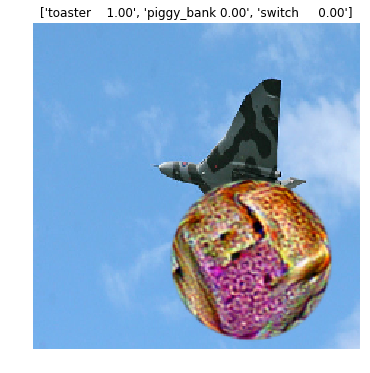

In [34]:
predict_model(model, patched_images[0, :, :, :])

##### example 2

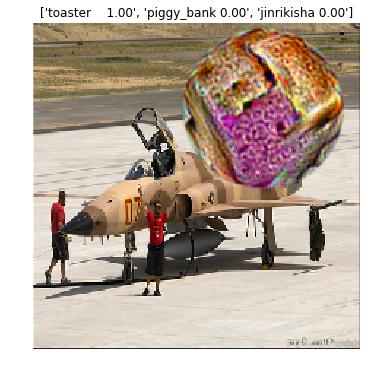

In [35]:
predict_model(model, patched_images[1, :, :, :])

##### example 3

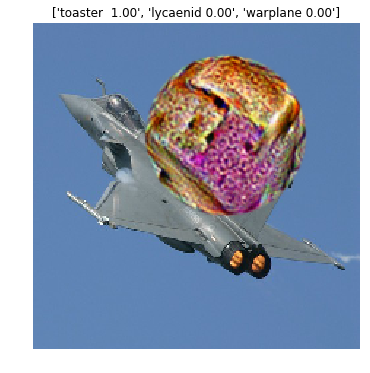

In [36]:
predict_model(model, patched_images[2, :, :, :])

### Reference

Brown, T., Mane D., Roy A. Abadi M. and Gilmer J. (2017). Adversarial Patch. *31st Conference on Neural Information Processing Systems*. https://arxiv.org/pdf/1712.09665.pdf